<h1>Import Necessary Libraries</h1>

In [1]:

import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr

from typing import Union, Tuple
from utils import *
import segmentation_models_3D as sm
from volumentations import *
import cv2
import keras
import tensorflow as tf
from keras import Model, Input


from tqdm import tqdm
#from cupyx.scipy.ndimage import zoom
#import cupy as cp
#from sklearn.model_selection import KFold
#%matplotlib widget

2025-01-15 11:41:39.799994: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `keras` framework.


<h1>Data Processing: reading all the seismic volumes and masks</h1>
<h5>Warning: RAM 110GB required!</h5

In [2]:
# Directory path for input files
training_data = os.path.join(
    os.getcwd(), "training_data"
)  # 'path to your training data'

# List to store the names of subfolders (sample IDs)
sample_ids = []

# Iterate over the items in the directory
for item in os.listdir(training_data):
    item_path = os.path.join(training_data, item)
    if os.path.isdir(item_path):
        sample_ids.append(item)

In [3]:

seismic_rescaled = []
fault = []

for idx in tqdm(range(len(sample_ids))):
    # Choosing one of the samples
    sample_id = sample_ids[idx]
    
    # Path to the subfolder/sample
    sample_path = os.path.join(training_data, sample_id)
    
    # List and print all files in the sample subfolder
    files = os.listdir(sample_path)
    #print("\n Files in the sample subfolder:", files)
    
    # Iterate over the files and load the .npy files.

    for file in files:
        if file.startswith("seismicCubes_") and file.endswith(".npy"):
            seismic = np.load(os.path.join(sample_path, file), allow_pickle=True)

            #seismic_rescaled.append(zoom(cp.asarray(rescale_volume(seismic, low=2, high=98).astype(np.uint8)), (1/2,1/2,1/2)).get())    
            seismic_rescaled.append(rescale_volume(seismic, low=2, high=98).astype(np.uint8))
            
        elif file.startswith("fault_") and file.endswith(".npy"):
            fault.append(np.load(os.path.join(sample_path, file), allow_pickle=True))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [28:23<00:00,  4.26s/it]


<h1>Dataset Splitting: 80:20 for train, val</h1>

In [4]:
#fold 0, indices of seismic volumes randomly split, indices saved in folds.txt

train_indices = [80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,\
98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,\
116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,\
134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,\
152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,\
170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,\
188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,\
206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,\
224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,\
242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,\
260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,\
278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,\
296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,\
314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,\
332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,\
350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,\
368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,\
386,387,388,389,390,391,392,393,394,395,396,397,398,399]

valid_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,\
19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,\
40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,\
62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79]



<h1>Splitting and reorganizing indices</h1>
<h4>each sample will be divided into four volumes of length 320 along depth</h4>

In [5]:
new_train_indices = []
for idx in train_indices:
    new_train_indices.append(idx*4)
    new_train_indices.append(idx*4+1)
    new_train_indices.append(idx*4+2)
    new_train_indices.append(idx*4+3)

new_valid_indices = []
for idx in valid_indices:
    new_valid_indices.append(idx*4)
    new_valid_indices.append(idx*4+1)
    new_valid_indices.append(idx*4+2)
    new_valid_indices.append(idx*4+3)  

<h1>Data Augmentation of 3D volumes</h1>

In [6]:
random.seed(117)
IMG_SIZE = 320
BATCH_SIZE = 2

BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)


AUGMENTATION_TRAIN = Compose([
    #CropNonEmptyMaskIfExists(shape=(IMG_SIZE, IMG_SIZE, IMG_SIZE), p=1),
    #RandomCrop(shape=(IMG_SIZE, IMG_SIZE, IMG_SIZE), p=1),
    #ResizedCropNonEmptyMaskIfExists(shape=(IMG_SIZE, IMG_SIZE, IMG_SIZE), scale_limit=(0.9, 1.1), interpolation=cv2.INTER_CUBIC, resize_type=0, p=1),

    Flip(0, p=0.3),
    Flip(1, p=0.3),
    Flip(2, p=0.3), 
    #RandomRotate90(p=0.4),
    #GridDistortion(distort_limit=0.4, interpolation=cv2.INTER_CUBIC, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.8),
    #Rotate((-10, 10), (-10, 10), (-10, 10), p=0.3),
    #RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    #ElasticTransform(deformation_limits=(0.1, 0.3), p=0.4),
    #RandomCropFromBorders(crop_value=0.2, p=0.2),
    
])


AUGMENTATION_VALID = Compose([
    #RandomCrop(shape=(IMG_SIZE, IMG_SIZE, IMG_SIZE), p=1),
    #CropNonEmptyMaskIfExists(shape=(IMG_SIZE, IMG_SIZE, IMG_SIZE), p=1),
])

<h1>Data Generator</h1>
<h4>Cropping/padding applied to volumes. Seismic volumes of shape 320x320x320 and corresponding masks generated</h4>

In [7]:
class DarkVolume(keras.utils.Sequence):
    def __init__(self, indices, batch_size=BATCH_SIZE, augment=None, shuffle=False,**kwargs):
        super().__init__(**kwargs)

        self.shuffle = shuffle
        self.augment = augment
        self.batch_size = batch_size
        self.indexes = indices
        self.on_epoch_end()
        
    def __len__(self):
         return int(np.ceil(len(self.indexes) / self.batch_size))
    
    def __getitem__(self, idx):

        start = idx * self.batch_size
        end = idx * self.batch_size + self.batch_size

        X, y = self.__data_generation(range(start,end))
        return X[...,np.newaxis], y[...,np.newaxis]

    def __data_generation(self, indices):
        images, masks = [], []

        #dx, dy control the degree of padding in respective directions,
        #delta controls cropping along the z axis; 
        #starting from delta seismic volumes of length=320 are cropped
        #helps in augmentation
        dx, dy, delta = 0, 0, 0 
        
        for j in indices:

            if self.augment == AUGMENTATION_TRAIN:
                delta = random.randint(0, 320-1)
            
            image = np.zeros((320,320,320), dtype=np.float32)
            mask = np.zeros((320,320,320), dtype=np.uint8)
            
            
            if self.indexes[j]//4 < len(seismic_rescaled):

                if self.augment == AUGMENTATION_TRAIN:
                    dx = random.randint(-10, 10)
                    dy = random.randint(-10, 10)
                
                z = (self.indexes[j]%4)*320 + delta

                img_data = seismic_rescaled[self.indexes[j]//4][0:300, 0:300, z:min(z+320, 1259)]/255.0
                msk_data = fault[self.indexes[j]//4][0:300, 0:300, z:min(z+320, 1259)]
                _, _, dz = msk_data.shape
                image[10-dx:310-dx, 10-dy:310-dy, 0:dz] = img_data
                mask[10-dx:310-dx, 10-dy:310-dy, 0:dz] = msk_data
                
                                    
                transformed = self.augment(image=image, mask=mask) 
                image1, mask1 = transformed['image'], transformed['mask']     
                images.append(preprocess_input(image1))
                #images.append(image1)
                masks.append(mask1)

        return np.array(images), np.array(masks).astype(np.float32)
        
    def on_epoch_end(self):       
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

<h1>Define volume generators for training, validation</h1>

In [8]:
train_ds = DarkVolume(new_train_indices, augment=AUGMENTATION_TRAIN, shuffle=True)
valid_ds = DarkVolume(new_valid_indices, augment=AUGMENTATION_VALID, shuffle=False)

<h1>Load sample volume-fault pairs and visualize</h1>

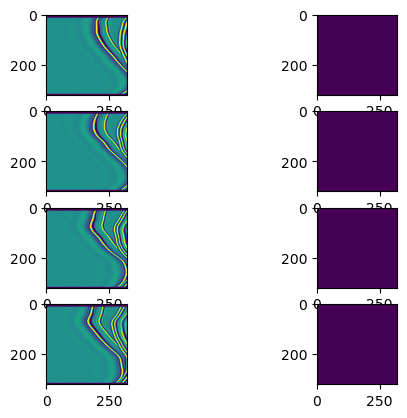

In [9]:
images, masks = train_ds.__getitem__(12)  #get 13th batch of train_ds
idx = 0  #first sample of batch

#display snapshots at 4 locations of the volume
fig, ax = plt.subplots(4,2)
ax[0,0].imshow(images[idx,20,:,:,0])
ax[0,1].imshow(masks[idx,20,:,:,0])
ax[1,0].imshow(images[idx,60,:,:,0])
ax[1,1].imshow(masks[idx,60,:,:,0])
ax[2,0].imshow(images[idx,90,:,:,0])
ax[2,1].imshow(masks[idx,90,:,:,0])
ax[3,0].imshow(images[idx,110,:,:,0])
ax[3,1].imshow(masks[idx,110,:,:,0])


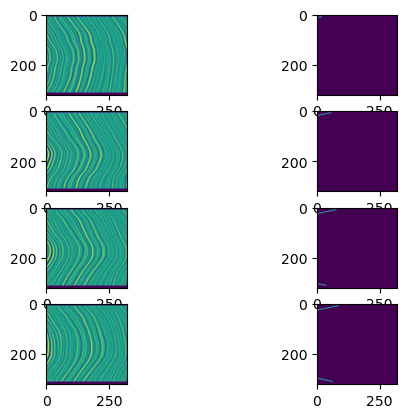

In [10]:
images, masks = valid_ds.__getitem__(1) #get second batch of valid_ds
idx = 0  #first sample of batch

#display snapshots at 4 locations of the volume
fig, ax = plt.subplots(4,2)
ax[0,0].imshow(images[idx,20,:,:,0])
ax[0,1].imshow(masks[idx,20,:,:,0])
ax[1,0].imshow(images[idx,60,:,:,0])
ax[1,1].imshow(masks[idx,60,:,:,0])
ax[2,0].imshow(images[idx,90,:,:,0])
ax[2,1].imshow(masks[idx,90,:,:,0])
ax[3,0].imshow(images[idx,110,:,:,0])
ax[3,1].imshow(masks[idx,110,:,:,0])

<h1>Model Definition and checkpoint loading</h1>

In [11]:

#Unet with Resnet50 backbone
model = sm.Unet(
    BACKBONE, 
    input_shape=(IMG_SIZE, IMG_SIZE, IMG_SIZE, 1), #single channel
    encoder_weights=None, #no pre-trained weights, training from scratch
    classes=1
)

#load model checkpoint
model.load_weights('darkvol_unet0_86.3.weights.h5') 

#optionally freeze BN layers at some stage of training
for layer in model.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False
        


2025-01-15 12:10:07.462699: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-15 12:10:07.511205: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-15 12:10:07.511531: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<h1>Define loss, metrics and optimizer to be used for training</h1>

### We used a custom hybrid loss as follows:
1. squared dice loss [<a href='https://arxiv.org/pdf/1606.04797'>Milletari et al. (2016)</a> proposed to change the denominator to the squared form for faster convergence.]
2. binary focal loss
3. structural similarity loss

### Optimizer
AdamW with gradient accumulation steps=10. No pre-determined learning rate scheduler was used. Training of this scale was expected to continue for several days with high chances of power outages/restarts, experimentation with hyperparameters, loss functions and combinations thereof.

In [12]:
#squared dice loss
def dice_loss(y_true, y_pred, smooth=1e-5):        
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    loss = 1. - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f * y_true_f) + \
                                                 tf.keras.backend.sum(y_pred_f * y_pred_f) + smooth)
    return loss

#binary focal loss
def binary_focal_loss(y_true, y_pred):        
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    return keras.losses.binary_focal_crossentropy(y_true_f, y_pred_f)

#structural similarity loss
def ssim_loss(y_true, y_pred):
    return 1. - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
    
def custom_loss(y_true, y_pred):
    return 1000.0 * ssim_loss(y_true, y_pred) + dice_loss(y_true, y_pred) + 100.0 * binary_focal_loss(y_true, y_pred)

'''
model.load_weights('darkvol_unet0_86.weights.h5') 
#freeze BN layers
for layer in model.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

'''
optimizer_func = keras.optimizers.AdamW(learning_rate = 4e-5, gradient_accumulation_steps=10) 

model.compile(optimizer=optimizer_func, loss=[ custom_loss ], \
              metrics=[sm.metrics.FScore(threshold=0.45)])

<h1>Fit the Model</h1>

In [ ]:

checkpoint_cb = keras.callbacks.ModelCheckpoint('darkvol_unet0.weights.h5',
                                                   monitor='val_f1-score',
                                                   mode='max', verbose=1,
                                                   save_best_only=True,
                                                   save_weights_only=True)

history = model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=1000,
                    callbacks=[checkpoint_cb])


Epoch 1/1000


W0000 00:00:1736936337.742077    8709 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert/Assert
W0000 00:00:1736936337.742940    8709 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_1/Assert
W0000 00:00:1736936337.743746    8709 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_2/Assert
W0000 00:00:1736936337.744354    8709 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_3/Assert
2025-01-15 15:49:02.315159: W external/local_xla/xla/service/hlo_rematerialization.cc:2941] Can't reduce memory use below 34.62GiB (37169171017 bytes) by rematerialization; only reduced to 36.36GiB (39038635764 bytes), down from 49.54GiB (53197438325 bytes) originally


640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1-score: 0.8767 - loss: 5.0133

W0000 00:00:1736937912.141658    8709 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert/Assert
W0000 00:00:1736937912.142512    8709 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_1/Assert
W0000 00:00:1736937912.143190    8709 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_2/Assert
W0000 00:00:1736937912.143636    8709 assert_op.cc:38] Ignoring Assert operator compile_loss/custom_loss/SSIM/Assert_3/Assert



Epoch 1: val_f1-score improved from -inf to 0.86155, saving model to darkvol_unet0.weights.h5
640/640 ━━━━━━━━━━━━━━━━━━━━ 1793s 3s/step - f1-score: 0.8767 - loss: 5.0138 - val_f1-score: 0.8616 - val_loss: 6.1866
Epoch 2/1000
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1-score: 0.8418 - loss: 5.5787
Epoch 2: val_f1-score improved from 0.86155 to 0.86195, saving model to darkvol_unet0.weights.h5
640/640 ━━━━━━━━━━━━━━━━━━━━ 1761s 3s/step - f1-score: 0.8418 - loss: 5.5780 - val_f1-score: 0.8619 - val_loss: 6.1939
Epoch 3/1000
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1-score: 0.8528 - loss: 5.6972
Epoch 3: val_f1-score did not improve from 0.86195
640/640 ━━━━━━━━━━━━━━━━━━━━ 1757s 3s/step - f1-score: 0.8528 - loss: 5.6966 - val_f1-score: 0.8608 - val_loss: 6.2222
Epoch 4/1000
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1-score: 0.8557 - loss: 5.3641
Epoch 4: val_f1-score improved from 0.86195 to 0.86195, saving model to darkvol_unet0.weights.h5
640/640 ━━━━━━━━━━━━━━━━━━━━ 1770s 3s/step

2025-01-15 20:14:39.720762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 7 of 8
2025-01-15 20:14:41.338368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1-score: 0.8600 - loss: 5.2987
Epoch 10: val_f1-score did not improve from 0.86337
640/640 ━━━━━━━━━━━━━━━━━━━━ 1763s 3s/step - f1-score: 0.8600 - loss: 5.2985 - val_f1-score: 0.8632 - val_loss: 6.1364
Epoch 11/1000
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1-score: 0.8291 - loss: 5.0454
Epoch 11: val_f1-score did not improve from 0.86337
640/640 ━━━━━━━━━━━━━━━━━━━━ 1760s 3s/step - f1-score: 0.8291 - loss: 5.0455 - val_f1-score: 0.8630 - val_loss: 6.0883
Epoch 12/1000
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1-score: 0.8658 - loss: 4.3194
Epoch 12: val_f1-score did not improve from 0.86337
640/640 ━━━━━━━━━━━━━━━━━━━━ 1780s 3s/step - f1-score: 0.8658 - loss: 4.3202 - val_f1-score: 0.8633 - val_loss: 6.1248
Epoch 13/1000
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1-score: 0.8559 - loss: 5.8892
Epoch 13: val_f1-score improved from 0.86337 to 0.86351, saving model to darkvol_unet0.weights.h5
640/640 ━━━━━━━━━━━━━━━━━━━━ 1770s 3s/step - f1-sco

2025-01-16 02:08:47.115509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 6 of 8
2025-01-16 02:08:49.915467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1-score: 0.8490 - loss: 4.7872
Epoch 22: val_f1-score did not improve from 0.86433
640/640 ━━━━━━━━━━━━━━━━━━━━ 1766s 3s/step - f1-score: 0.8490 - loss: 4.7873 - val_f1-score: 0.8632 - val_loss: 6.0903
Epoch 23/1000
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1-score: 0.8767 - loss: 4.3691